<img src="../Pics/MLSb-T.png" width="160">
<br><br>
<center><u><H1>Emotion Recognition with LSTM and Attention</H1></u></center>

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



In [0]:
from keras import Model, Input
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, CuDNNLSTM, Dropout, TimeDistributed, Reshape, Activation, Dot
from keras.layers.wrappers import Bidirectional
from keras.utils import to_categorical
import numpy as np 
import pandas as pd
import random
import matplotlib.pyplot as plt; plt.rcdefaults()
from IPython.core.display import display, HTML
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [5]:
df = pd.read_csv("/content/drive/My Drive/Colab_Notebooks/data/emotion.data")
df.head(10)

Unnamed: 0                                               text emotions
0       27383  i feel awful about it too because it s my job ...  sadness
1      110083                              im alone i feel awful  sadness
2      140764  ive probably mentioned this before but i reall...      joy
3      100071           i was feeling a little low few days back  sadness
4        2837  i beleive that i am much more sensitive to oth...     love
5       18231  i find myself frustrated with christians becau...     love
6       10714  i am one of those people who feels like going ...      joy
7       35177  i feel especially pleased about this as this h...      joy
8      122177  i was struggling with these awful feelings and...      joy
9       26723    i feel so enraged but helpless at the same time    anger

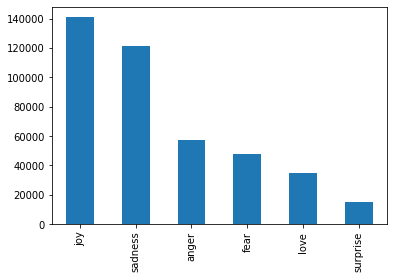

In [6]:
df.emotions.value_counts().plot.bar()

In [0]:
text_tokens = [text.split(" ") for text in df["text"].values.tolist()]
text = df["text"].values.tolist()
labels = df["emotions"].values.tolist()

In [8]:
print(df['text'][0])

i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here


In [9]:
print(text_tokens[0])

['i', 'feel', 'awful', 'about', 'it', 'too', 'because', 'it', 's', 'my', 'job', 'to', 'get', 'him', 'in', 'a', 'position', 'to', 'succeed', 'and', 'it', 'just', 'didn', 't', 'happen', 'here']


In [10]:
print(labels[0])

sadness


In [0]:
tokenizer = Tokenizer()

In [0]:
tokenizer.fit_on_texts(text)

In [0]:
word2id = tokenizer.word_index
id2word = dict([(value, key) for (key, value) in word2id.items()])

In [14]:
print(word2id)

{'i': 1, 'feel': 2, 'and': 3, 'to': 4, 'the': 5, 'a': 6, 'feeling': 7, 'that': 8, 'of': 9, 'my': 10, 'in': 11, 'it': 12, 'like': 13, 'so': 14, 'for': 15, 'im': 16, 'have': 17, 'me': 18, 'but': 19, 'was': 20, 'is': 21, 'this': 22, 'am': 23, 'with': 24, 'not': 25, 'be': 26, 'about': 27, 'as': 28, 'on': 29, 'you': 30, 'just': 31, 'when': 32, 'at': 33, 'or': 34, 'all': 35, 'because': 36, 'more': 37, 'do': 38, 'can': 39, 'really': 40, 'up': 41, 't': 42, 'know': 43, 'by': 44, 'are': 45, 'very': 46, 'been': 47, 'out': 48, 'myself': 49, 'what': 50, 'if': 51, 'time': 52, 'how': 53, 'get': 54, 'little': 55, 'will': 56, 'had': 57, 'now': 58, 'from': 59, 'being': 60, 'people': 61, 'they': 62, 'would': 63, 'he': 64, 'her': 65, 'want': 66, 'one': 67, 'think': 68, 'them': 69, 'still': 70, 'some': 71, 'ive': 72, 'even': 73, 'who': 74, 'much': 75, 'an': 76, 'we': 77, 'life': 78, 'him': 79, 'its': 80, 'there': 81, 'something': 82, 's': 83, 'things': 84, 'way': 85, 'bit': 86, 'm': 87, 'make': 88, 'love':

In [15]:
vocab_size = len(word2id) + 1
vocab_size

75303

## Generating data:

In [0]:
embedding_dim = 100
max_len = 150

In [17]:
X = [[word2id[word] for word in sent] for sent in text_tokens]
print(X[0])

[1, 2, 472, 27, 12, 94, 36, 12, 83, 10, 329, 4, 54, 79, 11, 6, 1159, 4, 2967, 3, 12, 31, 260, 42, 538, 134]


In [0]:
pad = 'post'
X_pad = pad_sequences(X, maxlen=max_len, padding=pad, truncating=pad)

In [19]:
print(X_pad[0])

[   1    2  472   27   12   94   36   12   83   10  329    4   54   79
   11    6 1159    4 2967    3   12   31  260   42  538  134    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


In [20]:
label2id = {l: i for i, l in enumerate(set(labels))}
id2label = {v: k for k, v in label2id.items()}
id2label

{0: 'sadness', 1: 'surprise', 2: 'love', 3: 'fear', 4: 'joy', 5: 'anger'}

In [0]:
y = [label2id[label] for label in labels]

In [0]:
y = to_categorical(y, num_classes=len(label2id), dtype='float32')

In [23]:
print("X (shape): {}".format(X_pad.shape))
print("y (shape): {}".format(y.shape))

X (shape): (416809, 150)
y (shape): (416809, 6)


## Creating the model:

In [24]:
seq_input = Input(shape=(max_len,), dtype='int32')

In [25]:
embedded = Embedding(vocab_size,
                     embedding_dim,
                     input_length=max_len)(seq_input)

In [26]:
embedded = Dropout(0.2)(embedded)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
lstm = Bidirectional(CuDNNLSTM(embedding_dim, return_sequences=True))(embedded)

In [0]:
lstm = Dropout(0.2)(lstm)

### Attention mechanism:

In [0]:
att_vector = TimeDistributed(Dense(1))(lstm)

In [0]:
att_vector = Reshape((max_len,))(att_vector)

In [0]:
att_vector = Activation('softmax', name='attention_vec')(att_vector)

In [0]:
att_output = Dot(axes=1)([lstm, att_vector])

### Final layers:

In [0]:
fc = Dense(embedding_dim, activation='relu')(att_output)

In [0]:
output = Dense(len(label2id), activation='softmax')(fc)

In [0]:
model = Model(inputs=[seq_input], outputs=output)

In [36]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 150, 100)     7530300     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 150, 100)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 150, 200)     161600      dropout_1[0][0]                  
____________________________________________________________________________________________

## Compiling the model:

In [37]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

## Training the model:

In [38]:
%%time
model.fit(X_pad, y, epochs=2, batch_size=64, validation_split=0.2, shuffle=True, verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 333447 samples, validate on 83362 samples
Epoch 1/2




 - 362s - loss: 0.2022 - acc: 0.9026 - val_loss: 0.0983 - val_acc: 0.9399
Epoch 2/2
 - 353s - loss: 0.0925 - acc: 0.9414 - val_loss: 0.0887 - val_acc: 0.9415
CPU times: user 7min 54s, sys: 2min 40s, total: 10min 35s
Wall time: 11min 56s


## Loading the Attention Layer:

In [0]:
model_att = Model(inputs=model.input,
                  outputs=[model.output, model.get_layer('attention_vec').output])

## Testing with a sample text:

In [51]:
sample_text = random.choice(df["text"].values.tolist())
print(sample_text)

i can count on her for anything and i feel so blessed to have her for my mother


In [0]:
tokenized_sample = sample_text.split(" ")
encoded_samples = [[word2id[word] for word in tokenized_sample]]

In [0]:
encoded_samples = pad_sequences(encoded_samples, maxlen=max_len)

In [0]:
label_probs, attentions = model_att.predict(encoded_samples)

### Probabilities for each class:

In [55]:
label_probs = {id2label[_id]: prob for (label, _id), prob in zip(label2id.items(),label_probs[0])}

print(label_probs)

{'sadness': 2.467789e-05, 'surprise': 1.6052543e-05, 'love': 0.5507866, 'fear': 1.1408465e-05, 'joy': 0.44910848, 'anger': 5.277812e-05}


### Attention vector in the text:

In [56]:
token_attention_dic = {}
max_score = 0.0
min_score = 0.0
for token, attention_score in zip(tokenized_sample, attentions[0][-len(tokenized_sample):]):
    token_attention_dic[token] = attention_score

print(token_attention_dic)

{'i': 0.00022276881, 'can': 1.3408643e-05, 'count': 2.8349523e-05, 'on': 3.2081876e-05, 'her': 0.0012502039, 'for': 0.0046075713, 'anything': 0.00016576148, 'and': 0.00025751226, 'feel': 0.01928262, 'so': 0.035183597, 'blessed': 0.92931646, 'to': 0.0029638929, 'have': 0.0027329172, 'my': 0.00093843124, 'mother': 0.002039255}


## Visualization:

In [0]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

In [0]:
def attention_color(attention_score):
    c = 255 - int(attention_score * 255)
    color = rgb_to_hex((c,255,c))
    return str(color)

### Visualizing attentions

In [0]:
html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
for word, att in token_attention_dic.items():
    html_text += "<span style='background-color:{};'>{} <span> ".format(attention_color(att), word)
html_text += "</p>"

In [60]:
display(HTML(html_text))

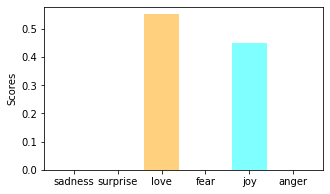

In [61]:
emotions = [label for label, _ in label_probs.items()]
scores = [score for _, score in label_probs.items()]
plt.figure(figsize=(5,3))
plt.bar(np.arange(len(emotions)), scores, align='center', alpha=0.5, color=['pink', 'red', 'orange', 'brown', 'cyan', "purple"])
plt.xticks(np.arange(len(emotions)), emotions)
plt.ylabel('Scores')
plt.show()